# How to use

Just execute the commands in order. You will need a valid geckodriver (for licensing purposes, not provided with this notebook)

In [52]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets

from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup

import pprint

# Start the driver

You need to set executable path of the geckodriver in executable_path. The geckodriver that is correct for your processor architecture can be found here: https://github.com/mozilla/geckodriver/releases




In [53]:
driver = webdriver.Firefox(executable_path='./geckodriver')
driver.implicitly_wait(5)
#ClimaTempo unfortunately takes a really long time to fully load, so we put a small timeout and catch the tiemoutException
driver.set_page_load_timeout(3)

# Load the first entry  point and acquire the states and cities data

In [54]:
try:
    #first entry point provided
    driver.get("https://www.climatempo.com.br/climatologia/2/santos-sp") 
except TimeoutException:
    pass

def read_states(page):
    # Wait to load the dropdown list
    WebDriverWait(driver, 20).until(
        EC.invisibility_of_element_located((By.XPATH, "//select[@id='sel-state-geo']/option[@value='']")))
    WebDriverWait(driver, 5).until(
        EC.invisibility_of_element_located((By.XPATH, "//select[@id='sel-state-geo']/option[@value='0']")))
    
    states_element = page.find_element_by_id("sel-state-geo")   
    states = [x for x in states_element.find_elements_by_tag_name("option")]
    return states



def read_cities(states):
    cities = []
    for state in states:
        if len(cities) >= 100:
            print("Getting at least the only first 100 to faster processing...")
            return cities
        print("State loaded: {}({})".format(state.text, state.get_attribute("value")))
        state.click()
        
        # Wait to load the dropdown list
        WebDriverWait(driver, 5).until(
            EC.invisibility_of_element_located((By.XPATH, "//select[@id='sel-city-geo']/option[@value='0']")))
        
        cities_element_selector = driver.find_element_by_id("sel-city-geo")
        cities_elements = [x for x in cities_element_selector.find_elements_by_tag_name("option")]
        
        for city in cities_elements:
            cities.append((
                city.get_attribute("value")
                ,{ 
                "State": state.text,
                "City": city.text,
            }))
        
        
    return cities

elem = driver.find_element_by_xpath("/html/body/div[5]/div/div[2]/div[2]/div/div[2]/div[1]/div[1]/p[1]/span[2]")
elem.click()

states = read_states(driver)
cities = read_cities(states)

State loaded: Acre(AC)
State loaded: Alagoas(AL)
Getting at least the only first 100 to faster processing...


# Scrap into pages to acquire the data

In [55]:
def read_city_climatology(code, data):
    print("Scrapping data for {City}({State})".format(**data))
    try:
        #first entry point provided
        driver.get("https://www.climatempo.com.br/climatologia/{}/dummy".format(code)) 
    except TimeoutException:
        pass
        
    table_xpath = "/html/body/div[5]/div/div[2]/div[2]/div/div[2]/div[1]/div[1]/div[3]/table/tbody"
    
    table_soup = BeautifulSoup(driver.find_element_by_xpath(table_xpath).get_attribute('outerHTML'))
    
    
    lines = table_soup.findChildren('tr')
    
    data['Climatology'] = [None]*12
    
    for index, columns in enumerate(lines):
        month = ''
        min_temp = 0
        max_temp = 0
        precipitation = 0
        for counter, column in enumerate(columns.findChildren('td')):
            if counter == 0:
                month = column.string
            elif counter == 1:
                min_temp = int(column.string.replace(u'\N{DEGREE SIGN}', ''))
            elif counter == 2:
                max_temp = int(column.string.replace(u'\N{DEGREE SIGN}', ''))
            elif counter == 3:
                precipitation = int(column.string)
                
        data['Climatology'][index] = {
            'Month': month,
            'Min': min_temp,
            'Max': max_temp,
            'Precipitation': precipitation
        }
        
for code, data in cities:
    read_city_climatology(code, data)

Scrapping data for Rio Branco(Acre)
Scrapping data for Acrelândia(Acre)
Scrapping data for Assis Brasil(Acre)
Scrapping data for Brasiléia(Acre)
Scrapping data for Bujari(Acre)
Scrapping data for Capixaba(Acre)
Scrapping data for Cruzeiro do Sul(Acre)
Scrapping data for Epitaciolândia(Acre)
Scrapping data for Feijó(Acre)
Scrapping data for Jordão(Acre)
Scrapping data for Mâncio Lima(Acre)
Scrapping data for Manoel Urbano(Acre)
Scrapping data for Marechal Thaumaturgo(Acre)
Scrapping data for Plácido de Castro(Acre)
Scrapping data for Porto Acre(Acre)
Scrapping data for Porto Walter(Acre)
Scrapping data for Rodrigues Alves(Acre)
Scrapping data for Santa Rosa do Purus(Acre)
Scrapping data for Senador Guiomard(Acre)
Scrapping data for Sena Madureira(Acre)
Scrapping data for Tarauacá(Acre)
Scrapping data for Xapuri(Acre)
Scrapping data for Maceió(Alagoas)
Scrapping data for Água Branca(Alagoas)
Scrapping data for Anadia(Alagoas)
Scrapping data for Arapiraca(Alagoas)
Scrapping data for Atala

# Analyze scrapped data

Dropdown(description='City:', options=('Rio Branco-(Acre)', 'Acrelândia-(Acre)', 'Assis Brasil-(Acre)', 'Brasi…

<IPython.core.display.Javascript object>


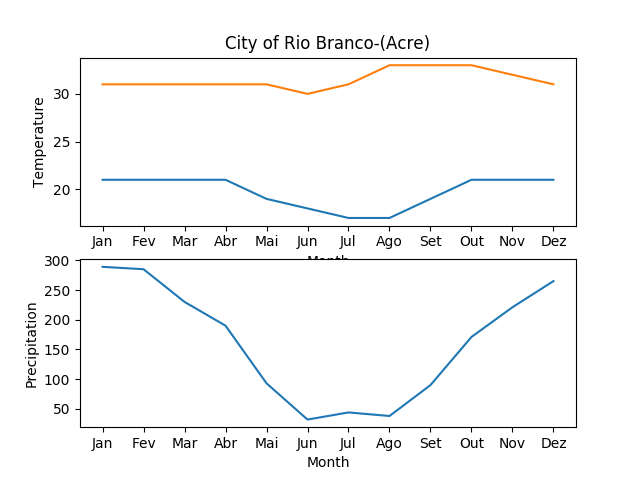

In [60]:
w = widgets.Dropdown(
    options=["{City}-({State})".format(**x) for _,x in cities],
    description='City:',
    disabled=False,
)


def display_chart(data):
    x = [x['Month'][0:3] for x in data['Climatology']]

    min_temp = [x['Min'] for x in data['Climatology']]
    max_temp = [x['Max'] for x in data['Climatology']]

    plt.clf()

    plt.subplot(2, 1, 1)                
    plt.title('City of {City}-({State})'.format(**data))
    plt.plot(x, min_temp, max_temp)
    plt.xlabel('Month')
    plt.ylabel('Temperature')

    plt.subplot(2, 1, 2)
    precipitation = [x['Precipitation'] for x in data['Climatology']]
    plt.plot(x, precipitation)
    plt.xlabel('Month')
    plt.ylabel('Precipitation')

    plt.show()


def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        for _, data in cities:
            if change['new'] == "{City}-({State})".format(**data):
                display_chart(data)
                break
                
w.observe(on_change)

display(w)
display_chart(cities[0][1])